# Introduction
In this notebook, we use regression techniques to predict sales of each product at a particular outlet of Big Mart. 

## Objective:
Using this model, BigMart will try to understand the properties of products and outlets which play a key role in increasing sales.

## Dataset
We have train (8523) and test (5681) data set, train data set has both input and output variable(s). We need to predict the sales for test data set.

    Variable:        	       Description
    Item_Identifier: 	       Unique product ID
    Item_Weight:    	       Weight of product
    Item_Fat_Content:	       Whether the product is low fat or not
    Item_Visibility:	       The % of total display area of all products 
                                in a store  allocated to the particular product
    Item_Type:      	       The category to which the product belongs
    Item_MRP:       	       Maximum Retail Price (list price) of the product
    Outlet_Identifier:	       Unique store ID
    Outlet_Establishment_Year: The year in which store was established
    Outlet_Size:               The size of the store in terms of ground area 
                                covered
    Outlet_Location_Type:      The type of city in which the store is located
    Outlet_Type:               Whether the outlet is just a grocery store or 
                                some sort of supermarket
    Item_Outlet_Sales:         Sales of the product in the particular store. 
                                This is the outcome variable to be predicted.
                                
                                
 ## Roadmap
 We use the following Machine Learning workflow in this notebook. 
 1. Data Cleaning and processing
 2. Exploratory Data Analysis
 3. Feature Engineering and Selection
 4. Develop models and evaluate them against a performance Metric
 5. Hyper-parameter tuning of best selected model
 6. Validate model on test set
 7. Draw conclusions
 
 

In [51]:
# Import Libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
%matplotlib inline
sns.set_style('ticks')
sns.set_palette('hls')
plt.style.use('ggplot')

pd.set_option('display.max_columns',30)

# Set no warnings against setting value on copy of slice
pd.options.mode.chained_assignment = None


# Data Cleaning and Processing

## Read data

In [2]:
import os
os.getcwd()

'/Users/kavyaannapareddy/Desktop/Projects/python/wip'

In [3]:
file_path_train= '/Users/kavyaannapareddy/Desktop/Projects/python/wip/big_mart_sales_train.csv'
file_path_test = '/Users/kavyaannapareddy/Desktop/Projects/python/wip/big_mart_sales_test.csv'
big_mart_train= pd.read_csv(file_path_train)
big_mart_test = pd.read_csv(file_path_test)

In [4]:
y_train = big_mart_train['Item_Outlet_Sales']

In [5]:
y_test_id = big_mart_test[['Item_Identifier','Outlet_Identifier']]

In [6]:
big_mart_train = big_mart_train.set_index(['Item_Identifier','Outlet_Identifier'])

In [7]:
big_mart_test = big_mart_test.set_index(['Item_Identifier','Outlet_Identifier'])

## Missing Values

In [8]:
# Create a function to calculate Missing values table
def missing_value(df):
  # missing values by column
  missing_val= df.isnull().sum()
  # % of missing values
  missing_val_percent = missing_val * 100/ len(df)
  # creating a table with values and percentage amounts
  missing_val_table = pd.concat([missing_val, missing_val_percent], axis=1)
  missing_val_table_rename= missing_val_table.rename(columns= {0:'missing values count', 1:'% of missing values'})
  missing_val_table_rename_sort= missing_val_table_rename[missing_val_table_rename.iloc[:,0]!=0].sort_values(by='missing values count', ascending=False).round(1)
  print('Your dataframe has {} columns of which {} contain missing values'.format(df.shape[1], len(missing_val_table_rename_sort)))


  return missing_val_table_rename_sort


missing_value(big_mart_train)

Your dataframe has 11 columns of which 2 contain missing values


,missing values count,% of missing values
Outlet_Size,2410,28.3
Item_Weight,1463,17.2


We have only two columns with missing values but a high percentage of them. We will impute them later with appropriate strategies.

In [9]:
num_var= ['Item_Weight','Item_Visibility','Item_MRP',
          'Outlet_Establishment_Year']
cat_var= ['Item_Fat_Content',  'Item_Type','Outlet_Size',
          'Outlet_Location_Type', 'Outlet_Type', 'Supermarket_Type']

# Exploratory Data Analysis

## Target Variable

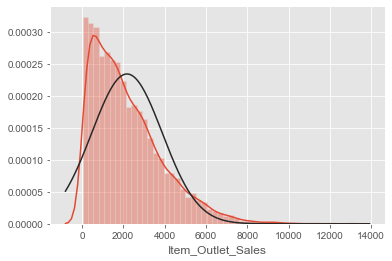

In [10]:
from scipy.stats import norm
sns.distplot(y_train, fit= norm)

Our target variable is skewed and needs to be transformed before applying regression algorithms as most assume normal distribution of variables.

## Numerical Variables

In [11]:
big_mart_train.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [12]:
big_mart_train['Outlet_Establishment_Year'].value_counts()

1985    1463
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: Outlet_Establishment_Year, dtype: int64

We can convert this variable to age of establishment as of 2013 as 2013 sales data has been provided to us.

In [13]:
now= 2013
big_mart_train['Outlet_Establishment_Year']= (now- big_mart_train['Outlet_Establishment_Year'])
big_mart_test['Outlet_Establishment_Year']= (now- big_mart_test['Outlet_Establishment_Year'])

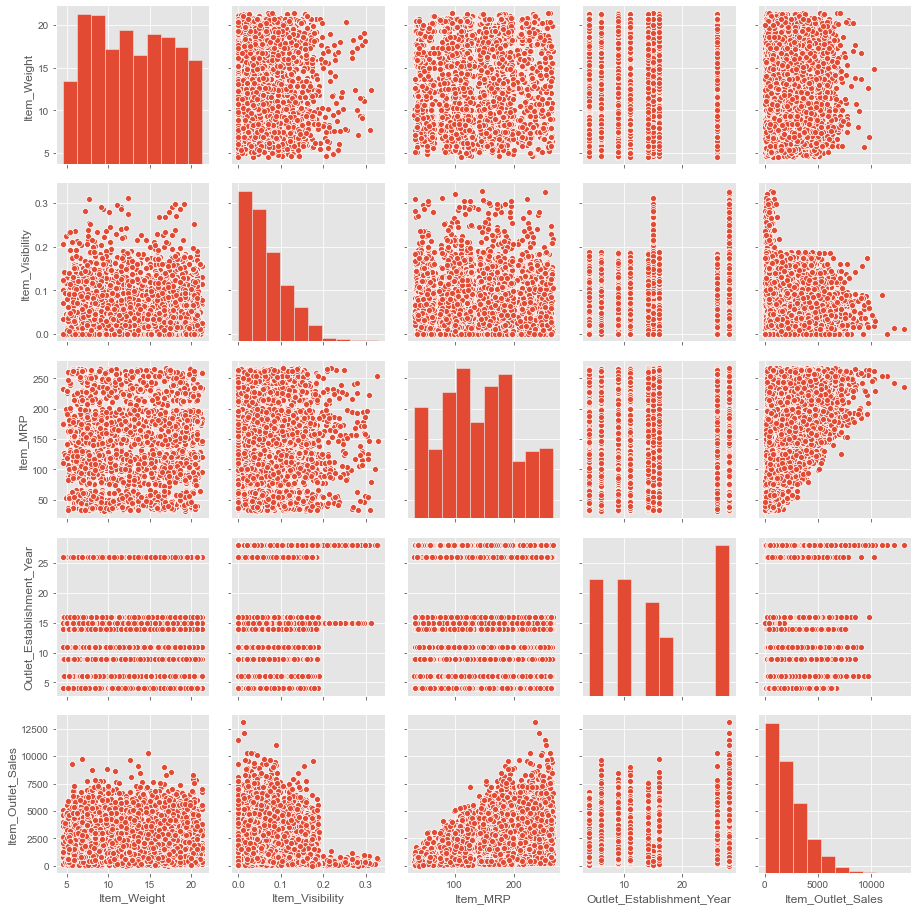

In [14]:
sns.pairplot(big_mart_train)

We observe that after a certain threshold in item_visibility, the outlet sales drop. Also as MRP increases, there is increase in sales. And more sales at older outlets. 

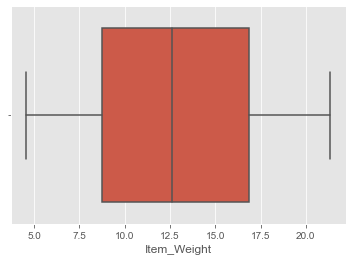

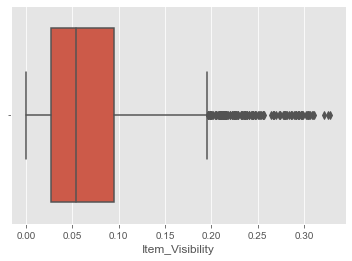

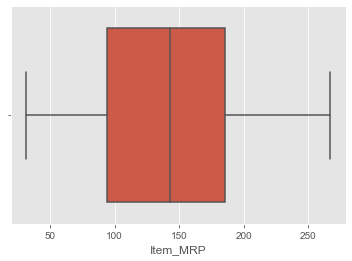

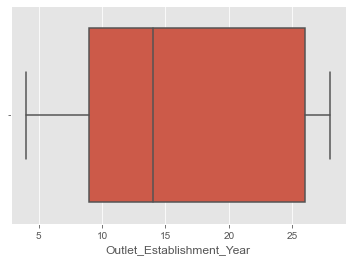

In [15]:
for feature in num_var:
    sns.boxplot(big_mart_train[feature])
    plt.show()
    

We observe a lot of outliers in item_visibility. We need to identify if these big objects belong to a certain product category. Also, there are values corresponding to 0. Although there could be values close to zero, exact zero doesn't make much sense. We will consider them as missing values and impute them.

# Categorical Variables

In [16]:
big_mart_train['Item_Fat_Content']= big_mart_train['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular' })
big_mart_test['Item_Fat_Content']= big_mart_test['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular' })

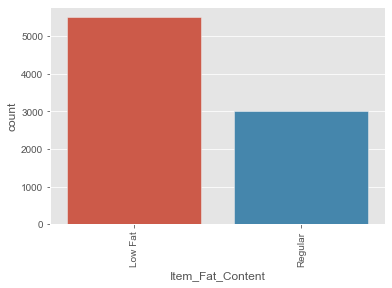

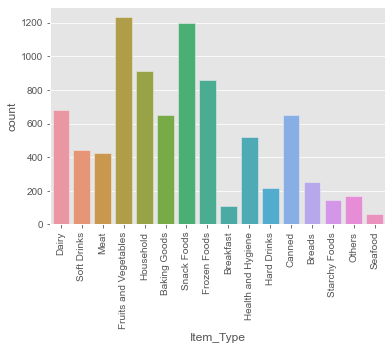

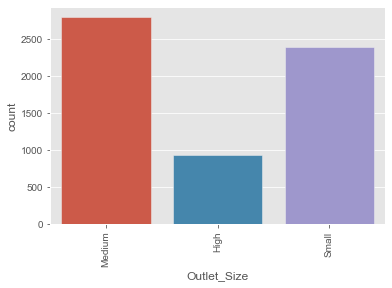

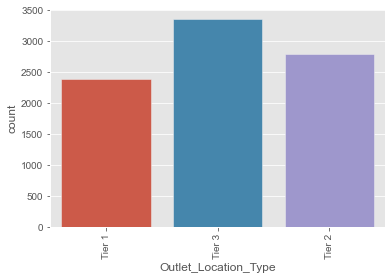

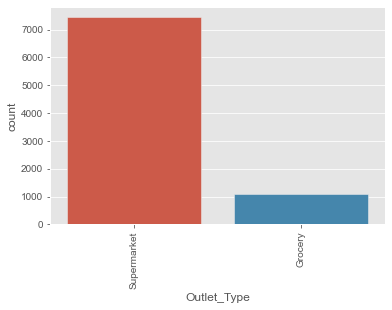

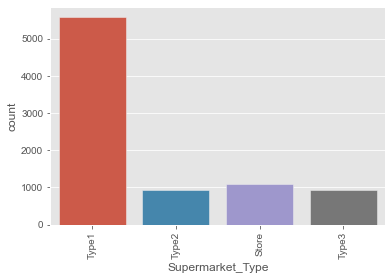

In [17]:
for feature in cat_var:
    sns.countplot(big_mart_train[feature])
    plt.xticks(rotation=90)
    plt.show()

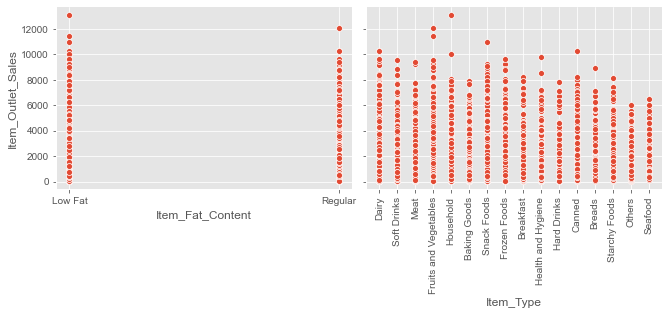

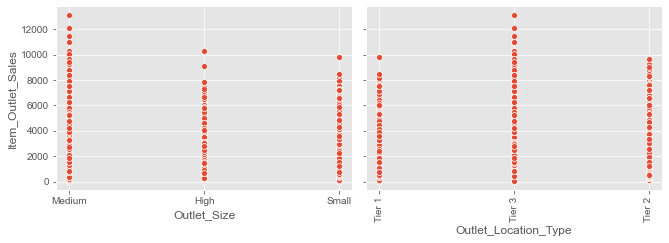

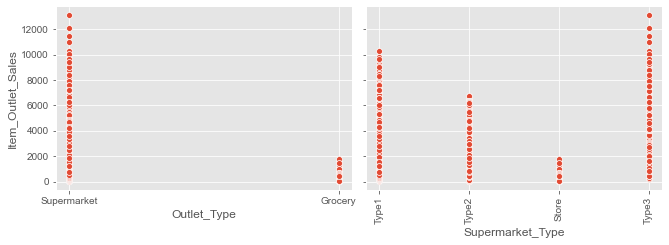

In [18]:
for i in range(0, len(cat_var),2):
    sns.pairplot(x_vars= cat_var[i:i+2], y_vars= 'Item_Outlet_Sales', 
                 data=big_mart_train, aspect=15/10, height=3)
    plt.xticks(rotation=90)

We observe that Supermarket has far more sales than a grocery store and within the supermarkets, type 3 has the highest sales followed by type1 and type2. Outlets located in tier 3 have highest sales. If the outlet size is small or high, it doesn't make much of a difference in sales while medium sized ones have higher sales per item. 

The item type categories are way too many and we need to find a way to reduce them to fewer categories.

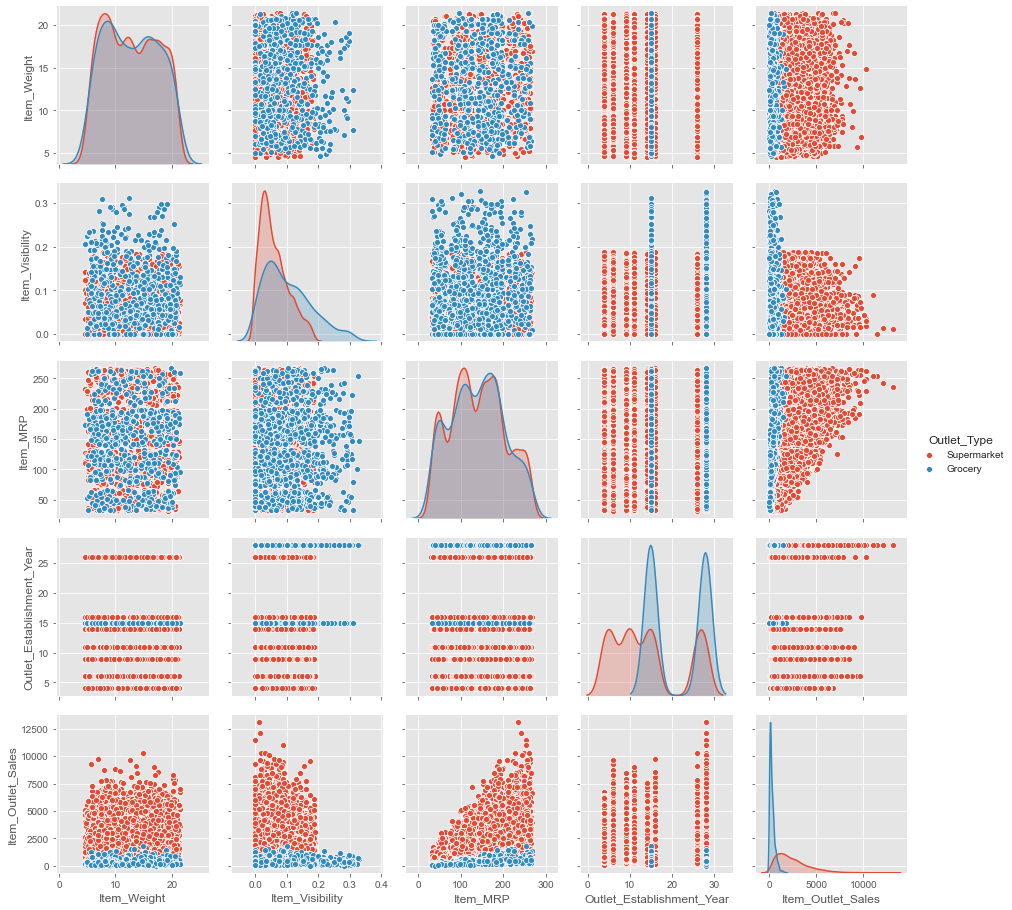

In [19]:
sns.pairplot(big_mart_train, hue= 'Outlet_Type')

Outlet type has an impact on sales. Grocery stores sell far less than supermarkets and are older. Since Supermarkets are usually stocked with far more items, their item visibility is lower. This also explains the outliers points we observed earlier. They all belong to Grocery store. 

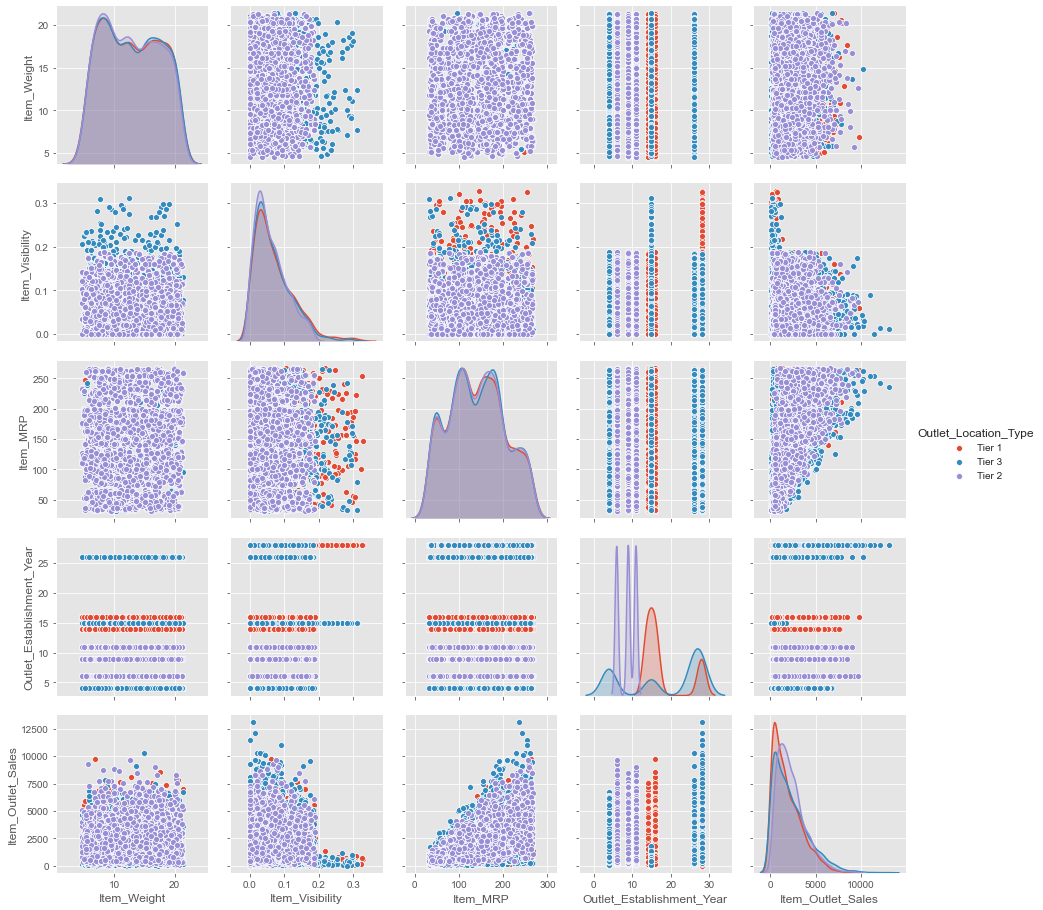

In [20]:
sns.pairplot(big_mart_train, hue= 'Outlet_Location_Type')

Tier 3 stores have been around a longer period of time and some relatively newer while Tier 2 stores are more recent. 

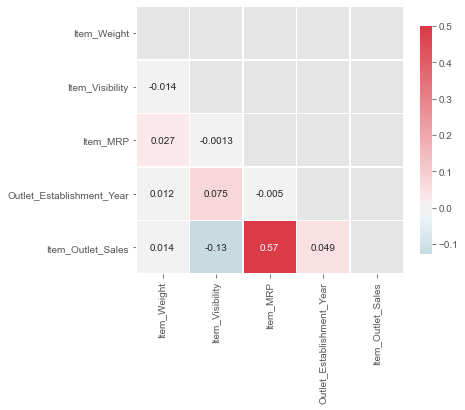

In [21]:
# heat map for numerical features
corr= big_mart_train.corr()

# generate a mask for upper traingle
mask = np.triu(np.ones_like(corr, dtype= np.bool))

# set up the matplotlib figure
fig, ax= plt.subplots(figsize= (6,6))

# generate a custom diverging colormap
cmap= sns.diverging_palette(220,10, as_cmap= True)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask= mask, cmap= cmap, vmax= 0.5, center= 0,annot= True ,
            square= True, linewidth= 0.5, cbar_kws={'shrink':0.7})

In [22]:
big_mart_train = big_mart_train.drop('Item_Outlet_Sales', axis=1)

# Feature Engineering and Scaling

## Dealing with missing values

We find values for imputation from training set and apply to both training and testing sets.

In [23]:
missing_value(big_mart_train)

Your dataframe has 10 columns of which 2 contain missing values


,missing values count,% of missing values
Outlet_Size,2410,28.3
Item_Weight,1463,17.2


In [24]:
from sklearn.impute import SimpleImputer
imp_mean= SimpleImputer(strategy= 'mean')
imp_mode= SimpleImputer(strategy = 'most_frequent')
imp_mean.fit(np.array(big_mart_train['Item_Weight']).reshape(-1,1))
big_mart_train['Item_Weight']=imp_mean.transform(np.array(big_mart_train['Item_Weight']).reshape(-1,1))
big_mart_test['Item_Weight']=imp_mean.transform(np.array(big_mart_test['Item_Weight']).reshape(-1,1))

In [25]:
imp_mode.fit(np.array(big_mart_train['Outlet_Size']).reshape(-1,1))
big_mart_train['Outlet_Size'] = imp_mode.transform(np.array(big_mart_train['Outlet_Size']).reshape(-1,1))
big_mart_test['Outlet_Size'] = imp_mode.transform(np.array(big_mart_test['Outlet_Size']).reshape(-1,1))

In [26]:
big_mart_train['Item_Visibility']=big_mart_train['Item_Visibility'].replace({0:np.mean(big_mart_train['Item_Visibility'])})
big_mart_test['Item_Visibility']=big_mart_test['Item_Visibility'].replace({0:np.mean(big_mart_train['Item_Visibility'])})


In [27]:
missing_value(big_mart_train)

Your dataframe has 10 columns of which 0 contain missing values


,missing values count,% of missing values


In [28]:
missing_value(big_mart_test)

Your dataframe has 10 columns of which 0 contain missing values


,missing values count,% of missing values


## Feature Engineering

We can club the item types into Food, Beverages and Other 

In [29]:
big_mart_train['Item_Type'].unique()

array(['Dairy', 'Soft Drinks', 'Meat', 'Fruits and Vegetables',
       'Household', 'Baking Goods', 'Snack Foods', 'Frozen Foods',
       'Breakfast', 'Health and Hygiene', 'Hard Drinks', 'Canned',
       'Breads', 'Starchy Foods', 'Others', 'Seafood'], dtype=object)

In [30]:
big_mart_train['Item_Type']=big_mart_train['Item_Type'].replace(['Dairy',  'Meat', 
                                                     'Fruits and Vegetables',
        'Baking Goods', 'Snack Foods', 'Frozen Foods',
       'Breakfast',   'Canned',
       'Breads', 'Starchy Foods', 'Seafood'],'Food')
big_mart_test['Item_Type']=big_mart_test['Item_Type'].replace(['Dairy',  'Meat', 
                                                     'Fruits and Vegetables',
        'Baking Goods', 'Snack Foods', 'Frozen Foods',
       'Breakfast',   'Canned',
       'Breads', 'Starchy Foods', 'Seafood'],'Food')

In [31]:
big_mart_train['Item_Type']=big_mart_train['Item_Type'].replace(['Soft Drinks','Hard Drinks'],'Beverages')
big_mart_test['Item_Type']=big_mart_test['Item_Type'].replace(['Soft Drinks','Hard Drinks'],'Beverages')

In [32]:
big_mart_train['Item_Type']=big_mart_train['Item_Type'].replace(['Household','Health and Hygiene','Others'],'Other')
big_mart_test['Item_Type']=big_mart_test['Item_Type'].replace(['Household','Health and Hygiene','Others'],'Other')

## Feature Scaling

### Transformation
First, we make our target variable more normal. Then one hot encode categorical features and scale numerical features.

As a general rule of thumb: If skewness is less than -1 or greater than 1, the distribution is highly skewed. If skewness is between -1 and -0.5 or between 0.5 and 1, the distribution is moderately skewed. If skewness is between -0.5 and 0.5, the distribution is approximately symmetric.

So, we apply box cox transformation to variables whose absolute value of sknewness is above 0.65

This transformation technique modifies the distribution of our variable so that its residuals more normally distributed. We need to estimate lambda from our training set. The value of lambda usually lies between -5 and 5 and controls the type of transformation.

Below are some common values for lambda:
1. lambda = -1. is a reciprocal transform.
2. lambda = -0.5 is a reciprocal square root transform.
3. lambda = 0.0 is a log transform.
4. lambda = 0.5 is a square root transform.
5. lambda = 1.0 is no transform.

I obtain lambda by using only the train dataset and apply it wholly.

In [33]:
from scipy.stats import skew
skew(y_train)

1.1773233539676373

0.34647755754885007


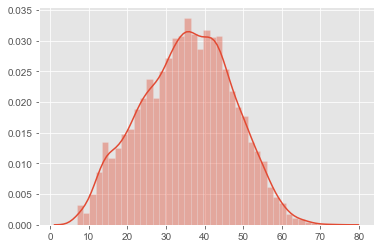

In [34]:
from scipy.stats import boxcox
y_train_bcx,y_lam= boxcox(y_train)
print(y_lam)
sns.distplot(y_train_bcx)

In [35]:
# check skewness in our numerical features before applying box cox transformation
skew_features= big_mart_train[num_var].apply(lambda x: skew(x))
skew_features.sort_values(ascending= False)

Item_Visibility              1.286650
Outlet_Establishment_Year    0.396571
Item_MRP                     0.127180
Item_Weight                  0.090546
dtype: float64

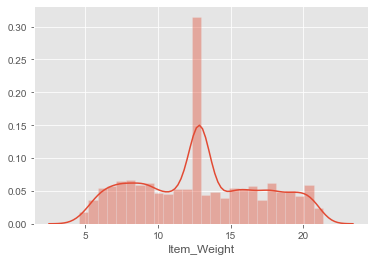

In [36]:
sns.distplot(big_mart_train['Item_Weight'])

In [37]:
big_mart_train['Item_Visibility'], lam =boxcox(big_mart_train['Item_Visibility'])
lam

0.24903955819585658

In [38]:
big_mart_test['Item_Visibility']= boxcox(big_mart_test['Item_Visibility'], lam)

### One-hot Encoding

In [39]:
big_mart_train_one_hot = pd.get_dummies(big_mart_train).drop('Supermarket_Type_Store', 
                                                 axis=1)
big_mart_test_one_hot = pd.get_dummies(big_mart_test).drop('Supermarket_Type_Store', 
                                                 axis=1)

### Scaling

In [40]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
scaler.fit(big_mart_train_one_hot )
big_mart_train_transform = scaler.transform(big_mart_train_one_hot )
big_mart_test_transform = scaler.transform(big_mart_test_one_hot )

In [41]:
X_train = big_mart_train_transform
y_train = y_train_bcx
X_test = big_mart_test_transform

# Model Evaluation
We apply the following models and select the best one:
1. Linear Regression
2. Ridge Regression
3. Lasso
4. Elastic Net
5. Random Forest
6. Support Vector Machine
7. K Nearest Neighbor
8. Bayesian Regression


## Performance Metric
We use Root Mean Square Error to evaluate the performance of the model

In [42]:
from sklearn.metrics import mean_squared_error
def rmse(y_pred, y_actual):
    mse= mean_squared_error(y_pred, y_actual)
    return math.sqrt(mse)

## Split dataset
We split our training data into train and validation datasets 

In [43]:
from sklearn.model_selection import train_test_split
X_train_split, X_valid_split, y_train_split, y_valid_split= train_test_split(X_train, 
                                    y_train, random_state= 42, test_size= 0.2)

## Apply Models

In [44]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
lr= LinearRegression()
rgd = Ridge()
lasso= Lasso()
elnet= ElasticNet()
from sklearn.ensemble import RandomForestRegressor
rf= RandomForestRegressor()
from sklearn.svm import SVR
svr = SVR()
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()
from sklearn.linear_model import BayesianRidge
br = BayesianRidge()
models={'Linear Regression': lr, 'Ridge':rgd, 'Lasso':lasso,
        'Elastic Net': elnet, 'Random Forest': rf,
        'Support Vector Machine': svr, 'K Nearest Neighbors': knn,
        'Bayesian':br}


In [45]:
from sklearn.model_selection import KFold, cross_val_score
results=[]
for model in models:
    kfold= KFold( n_splits=10, random_state=42, shuffle=True)
    score= cross_val_score(models[model], X_train_split, y_train_split, 
                           cv=kfold, scoring='neg_root_mean_squared_error')
    results.append(score)
    print('%s: %f, (%f)'%(model, np.mean(results), np.std(results)))

Linear Regression: -6.737224, (0.160161)
Ridge: -6.737175, (0.159995)
Lasso: -6.814436, (0.189060)
Elastic Net: -6.978813, (0.337884)
Random Forest: -6.978272, (0.308431)
Support Vector Machine: -6.921841, (0.312913)
K Nearest Neighbors: -6.968155, (0.318048)
Bayesian: -6.939281, (0.312255)


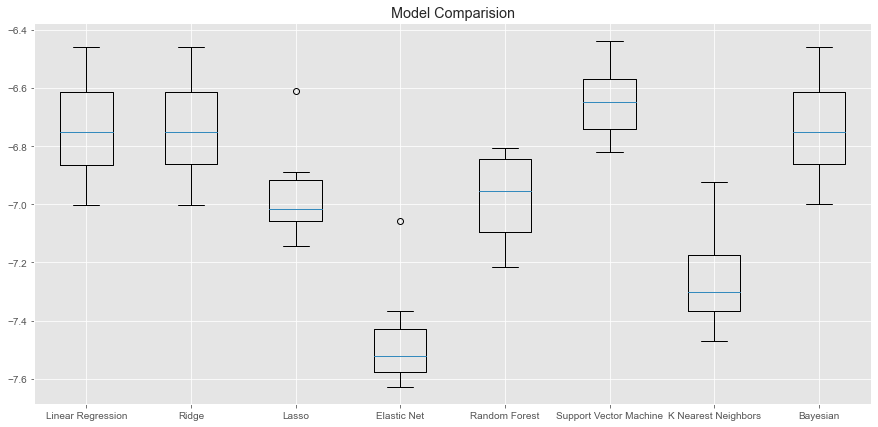

In [46]:
plt.figure(figsize= (15,7))
plt.title('Model Comparision')
plt.boxplot(results, labels= models.keys())
plt.show()

From our list of models, Support Vector Machine seems to be doing the best

# Hyper-parameter Tuning

In [47]:
svr

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [48]:
from sklearn.model_selection import GridSearchCV
# defining parameter range
param_grid= {'C':[0.01,0.1,1], 'kernel':['linear','rbf'],
            'gamma': [0.001, 0.01, 0.1, 1]}
grid= GridSearchCV(svr, param_grid, cv=5, 
                   scoring='neg_root_mean_squared_error', refit=True)

# fitting the model for grid search
grid.fit(X_train_split, y_train_split)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.01, 0.1, 1], 'gamma': [0.001, 0.01, 0.1, 1],
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=0)

In [49]:
print(grid.best_params_)

{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


# Validate the model

In [52]:
grid_pred= grid.predict(X_valid_split)
rmse(grid_pred, y_valid_split)

6.42437386890808

# Predict Values

In [54]:
svr_best = SVR(C=1, gamma= 0.01, kernel ='rbf')

In [55]:
svr_best.fit(X_train, y_train)
y_pred= svr_best.predict(X_test)

In [58]:
from scipy.special import inv_boxcox
y_pred_trans = inv_boxcox(y_pred,y_lam)

In [61]:
submit = pd.concat([y_test_id, pd.DataFrame(y_pred_trans)], axis= 1)

In [65]:
submit = submit.rename(columns={0:'Item_Outlet_Sales'})

In [66]:
submit.to_csv('sample_submission.csv', index= False)

# Conclusion
We applied various regression techniques to predict item sales per outlet for Big Mart Sales 3 dataset hosted on Analytics Vidhya. 

Your score for this submission is : 1178.5432358412888.